Data scaled.


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

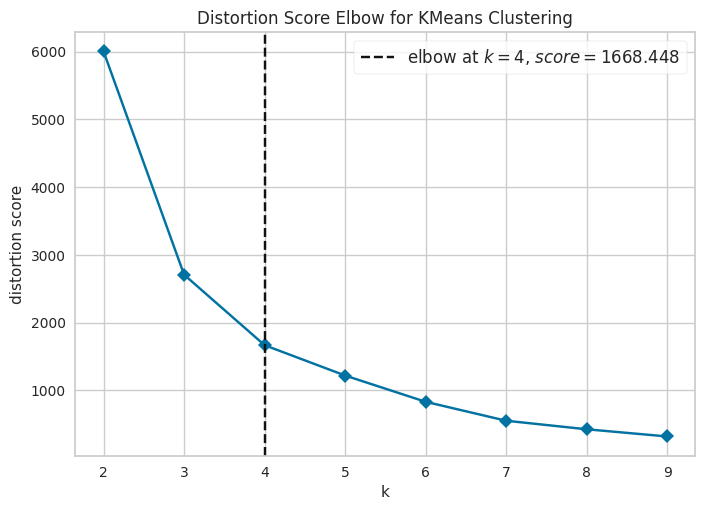

Optimal number of clusters: 4
Silhouette score for optimal number of clusters: 0.5873666565651813


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_33/3272281778.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Cluster_Labels'] = self.labels


K-Means applied with 4 clusters.
Cluster plot saved as cluster_plot_DTC.png
Clustered data saved to clustered_DTC.csv
           CALI  Cluster_Labels
0  19.406000137               1
1  19.406000137               1
2  19.406000137               1
3  19.452999115               1
4  19.452999115               1


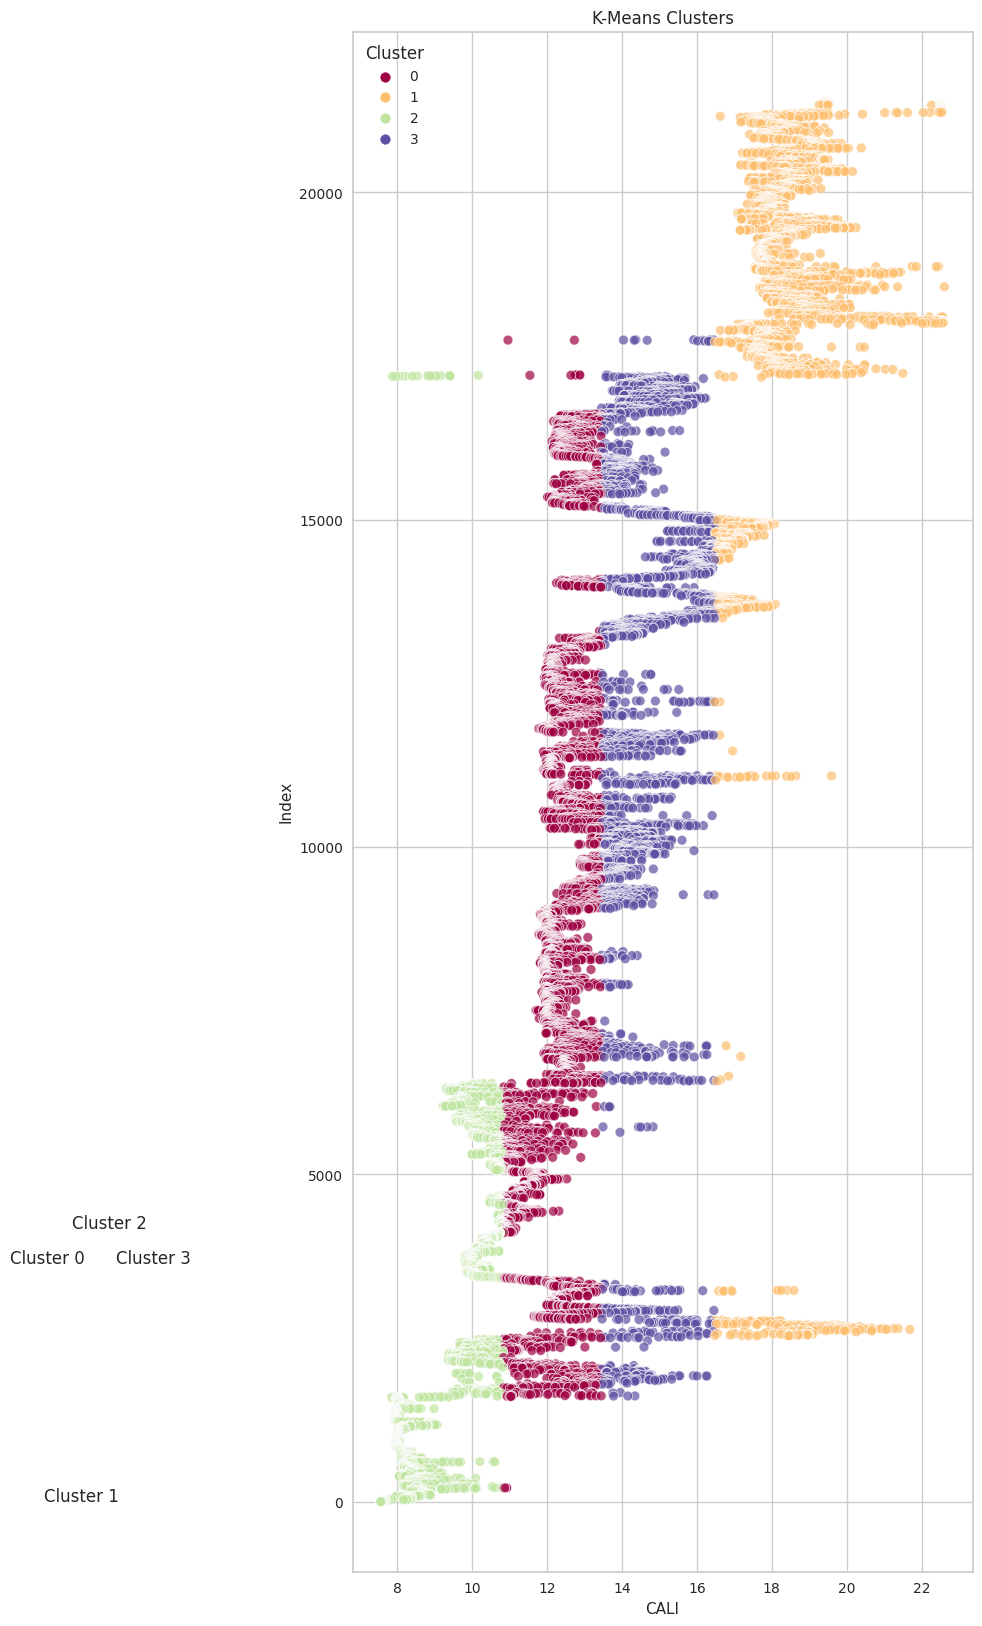

In [39]:
!pip install lasio mplstereonet fracture xcomposite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import lasio 
import mplstereonet as mpl
import fracture
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

#data links
well_path= "http://bit.ly/wireline-data"
trajectory_path= "http://bit.ly/trajectory-data"
fracture_path="http://bit.ly/fractures-data"
# Read LAS well log data
well=lasio.read(well_path)
#display mnemonics of well log
well.curves
#convert to dataframe to display as table
well_df=well.df().reset_index()
well_df2 = well_df[['CALI']]


class KMeansClustering:
    """
    Classe para realizar clustering usando K-Means.

    Attributes:
        data (pd.DataFrame or pd.Series): Os dados para clustering.
        data_scaled (pd.DataFrame): Dados normalizados.
        kmeans (KMeans): Objeto KMeans treinado.
        labels (np.ndarray): Labels de cluster atribuídas.
        optimal_n_clusters (int): Número ótimo de clusters determinado pelo método do cotovelo.
    """

    def __init__(self, data):
        """
        Inicializa a classe com os dados de entrada.

        Args:
            data (pd.DataFrame or pd.Series): Os dados para clustering.
        """
        self.data = data
        self.data_scaled = None
        self.kmeans = None
        self.labels = None
        self.optimal_n_clusters = None

    def preprocess_data(self):
        """
        Pré-processa os dados, incluindo normalização.
        """
        if isinstance(self.data, pd.Series):
            self.data = pd.DataFrame(self.data)
        # Verificar e tratar valores nulos
        if self.data.isnull().any().any():
            raise ValueError("Data contains null values. Please handle them before clustering.")
        
        # Normalizar os dados
        scaler = StandardScaler()
        self.data_scaled = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)
        print("Data scaled.")

    def find_optimal_n_clusters(self, max_clusters=10):
        """
        Encontra o número ótimo de clusters usando o método do cotovelo.

        Args:
            max_clusters (int): Número máximo de clusters a serem testados.
        """
        model = KMeans(random_state=42)
        visualizer = KElbowVisualizer(model, k=(2, max_clusters), timings=False)
        visualizer.fit(self.data_scaled)
        visualizer.show()

        # Definir o número ótimo de clusters com base no método do cotovelo
        self.optimal_n_clusters = visualizer.elbow_value_
        print(f"Optimal number of clusters: {self.optimal_n_clusters}")

        # Calcular e exibir o score de Silhouette
        silhouette_avg = silhouette_score(self.data_scaled, visualizer.labels_)
        print(f"Silhouette score for optimal number of clusters: {silhouette_avg}")

    def apply_kmeans(self):
        """
        Aplica K-Means com o número ótimo de clusters encontrado.
        """
        self.kmeans = KMeans(n_clusters=self.optimal_n_clusters, random_state=42)
        self.labels = self.kmeans.fit_predict(self.data_scaled)
        # Adicionar as labels ao DataFrame original
        self.data['Cluster_Labels'] = self.labels
        print(f"K-Means applied with {self.optimal_n_clusters} clusters.")

    def plot_clusters(self, save_fig=False, fig_name="cluster_plot.png"):
        """
        Plota o gráfico de dispersão dos clusters.

        Args:
            save_fig (bool): Se True, salva o gráfico como arquivo.
            fig_name (str): Nome do arquivo para salvar o gráfico (opcional).
        """
        if self.labels is None:
            print("K-Means not applied yet. Apply K-Means before plotting.")
            return

        plt.figure(figsize=(8, 20))
        sns.scatterplot(
            x=self.data.iloc[:, 0],
            y=self.data.index[::-1],
            hue="Cluster_Labels",
            data=self.data,
            palette="Spectral",
            s=50,
            alpha=0.7,
        )
        plt.title("K-Means Clusters")
        plt.xlabel(self.data.columns[0])
        plt.ylabel("Index")

        # Adicionar anotações para os centroides
        centroids = self.kmeans.cluster_centers_
        for i, label in enumerate(self.data["Cluster_Labels"].unique()):
            centroid_x = centroids[i, 0]
            centroid_y = self.data[self.data["Cluster_Labels"] == label].index.min()
            plt.text(centroid_x, centroid_y, f"Cluster {label}", ha="center")

        plt.legend(title="Cluster", loc="best")

        if save_fig:
            plt.savefig(fig_name, dpi=300, bbox_inches="tight")
            print(f"Cluster plot saved as {fig_name}")
        else:
            plt.show()

    def get_data(self):
        """
        Retorna os primeiros registros do dataframe.
        """
        return self.data.head()

    def save_data(self, filename="clustered_data.csv"):
        """
        Salva o dataframe modificado em um arquivo CSV.

        Args:
            filename (str): Nome do arquivo CSV para salvar os dados.
        """
        self.data.to_csv(filename, index=False)
        print(f"Clustered data saved to {filename}")


# Exemplo de uso da classe KMeansClustering
# Supondo que 'DTC' seja seu dataframe ou série de dados
# DTC = pd.Series([19.406, 19.406, 19.406, 19.453, 19.453], name='DTC')
kmeans_clustering = KMeansClustering(well_df2)

# Executar o processo de clustering
kmeans_clustering.preprocess_data()
kmeans_clustering.find_optimal_n_clusters(max_clusters=10)
kmeans_clustering.apply_kmeans()

# Plotar os clusters e opcionalmente salvar o gráfico
kmeans_clustering.plot_clusters(save_fig=True, fig_name="cluster_plot_DTC.png")

# Salvar o dataframe modificado
kmeans_clustering.save_data(filename="clustered_DTC.csv")

# Mostrar os primeiros registros do dataframe
print(kmeans_clustering.get_data())
